# Proof of Concept: Inverse Transforms for Forecasters

100%|██████████| 414/414 [00:00<00:00, 560.91it/s]


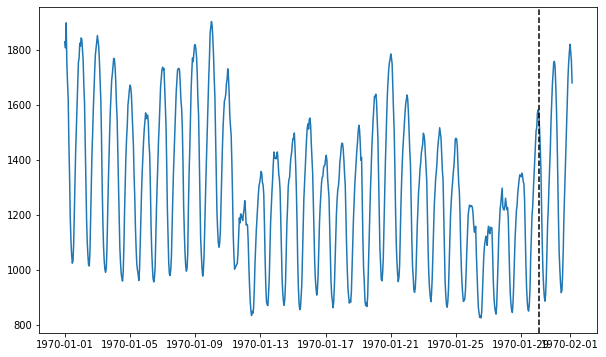

In [2]:
import matplotlib.pyplot as plt

from merlion.utils import TimeSeries
from ts_datasets.forecast import M4

ts, md = M4(subset="Hourly")[2]
train = TimeSeries.from_pd(ts[md["trainval"]])
test = TimeSeries.from_pd(ts[~md["trainval"]])

ax = plt.figure(figsize=(10, 6)).add_subplot(111)
ax.plot(ts)
ax.axvline(train.to_pd().index[-1], ls="--", c="k")
plt.show()

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

from merlion.evaluate.forecast import ForecastMetric
from merlion.models.forecast.base import ForecasterBase
from merlion.utils import TimeSeries

def eval_model(model: ForecasterBase, train_data: TimeSeries, test_data: TimeSeries,
               apply_inverse=True):
    og_train = train_data
    yhat_train, _ = model.train(train_data)
    if apply_inverse:
        yhat_train = model.transform.invert(yhat_train)
    else:
        train_data = model.transform(train_data)
    
    t = test_data.time_stamps
    yhat_test, _ = model.forecast(t)
    if apply_inverse:
        yhat_test = model.invert_transform(yhat_test)
    else:
        test_data = model.transform(og_train + test_data).align(reference=t)
    
    print(f"Train sMAPE: {ForecastMetric.sMAPE.value(train_data, yhat_train):.2f}")
    print(f"Test  sMAPE: {ForecastMetric.sMAPE.value(test_data, yhat_test):.2f}")

    ax = plt.figure(figsize=(10, 6)).add_subplot(111)
    ax.plot((train_data + test_data).to_pd(), label="true")
    ax.plot((yhat_train + yhat_test).to_pd(), label="model")
    ax.axvline(pd.to_datetime(t[0], unit="s"), c="k", ls="--")
    ax.legend()
    plt.show()
    return yhat_test
    

plotly not installed, so plotly visualizations will not work.


In [4]:
from merlion.models.forecast.prophet import Prophet, ProphetConfig
from merlion.transform.resample import TemporalResample
from merlion.transform.sequence import TransformSequence

def get_model(transform=None):
    if transform is not None:
        transform = TransformSequence([TemporalResample(), transform])
    prophet = Prophet(ProphetConfig(add_seasonality="auto", transform=transform))
    return prophet

Importing plotly failed. Interactive plots will not work.


No transform...


INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Train sMAPE: 4.79
Test  sMAPE: 16.50


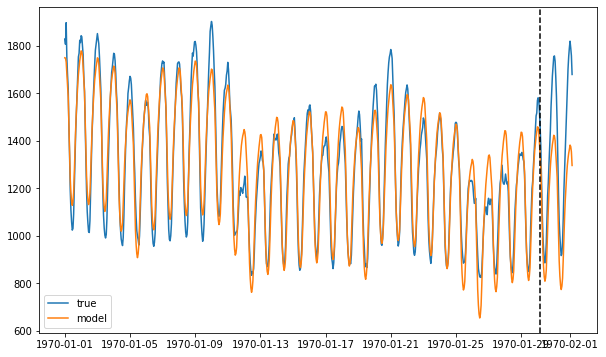

In [5]:
print("No transform...")
base = eval_model(get_model(), train, test, apply_inverse=True)

Normalize...


INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Train sMAPE: 54.02
Test  sMAPE: 116.71


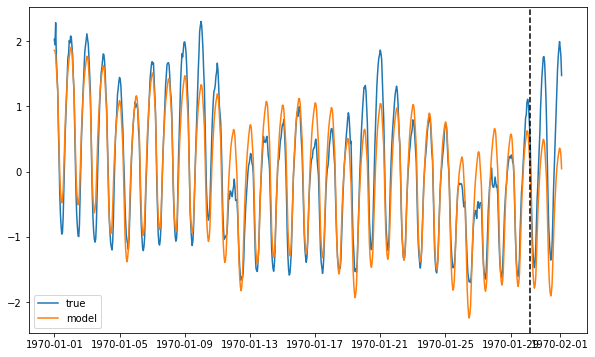

INFO:merlion.models.forecast.prophet:Add seasonality 24


Normalize + invert...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:merlion.transform.base:Transform TemporalResample(aggregation_policy=Mean, granularity=3600.0, missing_value_policy=Interpolate, origin=0.0, remove_non_overlapping=True, trainable_granularity=True) is not strictly invertible. Calling invert() is not guaranteed to recover the original time series exactly!
INFO:merlion.transform.base:Transform TemporalResample(aggregation_policy=Mean, granularity=3600.0, missing_value_policy=Interpolate, origin=0.0, remove_non_overlapping=True, trainable_granularity=True) is not strictly invertible. Calling invert() is not guaranteed to recover the original time series exactly!


Train sMAPE: 5.70
Test  sMAPE: 17.03


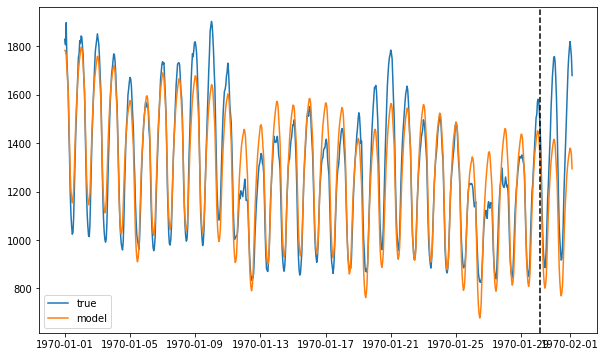

In [6]:
from merlion.transform.normalize import MeanVarNormalize, MinMaxNormalize

print("Normalize...")
eval_model(get_model(MeanVarNormalize()), train, test, apply_inverse=False)

print("Normalize + invert...")
norm = eval_model(get_model(MeanVarNormalize()), train, test, apply_inverse=True)

Log transform...


INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Train sMAPE: 0.46
Test  sMAPE: 1.21


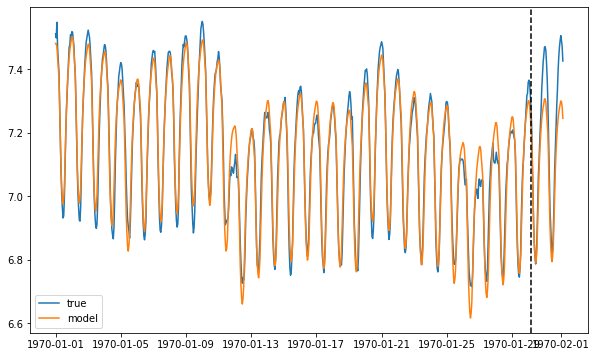

INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Log transform + invert...


INFO:merlion.transform.base:Transform TemporalResample(aggregation_policy=Mean, granularity=3600.0, missing_value_policy=Interpolate, origin=0.0, remove_non_overlapping=True, trainable_granularity=True) is not strictly invertible. Calling invert() is not guaranteed to recover the original time series exactly!
INFO:merlion.transform.base:Transform TemporalResample(aggregation_policy=Mean, granularity=3600.0, missing_value_policy=Interpolate, origin=0.0, remove_non_overlapping=True, trainable_granularity=True) is not strictly invertible. Calling invert() is not guaranteed to recover the original time series exactly!


Train sMAPE: 3.24
Test  sMAPE: 8.75


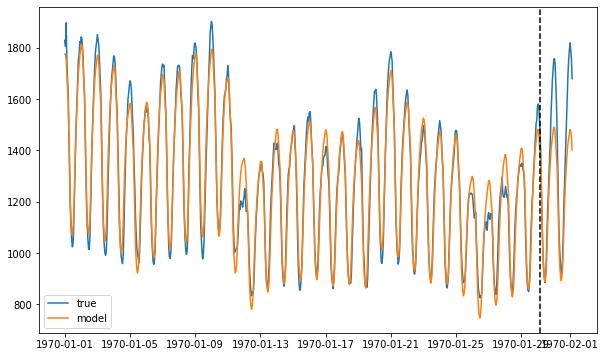

In [7]:
from merlion.transform.normalize import PowerTransform

print("Log transform...")
eval_model(get_model(PowerTransform()), train, test, apply_inverse=False)

print("Log transform + invert...")
log = eval_model(get_model(PowerTransform()), train, test, apply_inverse=True)

INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Moving Average...
Train sMAPE: 5.28
Test  sMAPE: 18.69


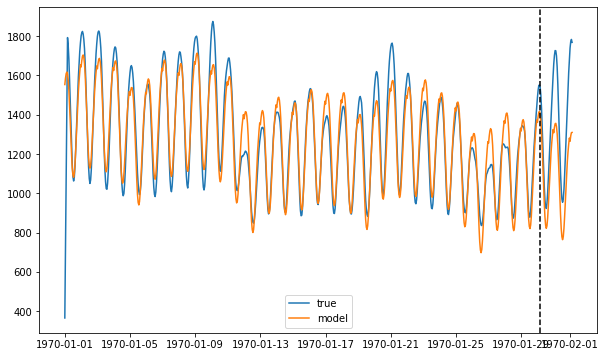

INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Moving Average + invert...


INFO:merlion.transform.base:Transform MovingAverage(n_steps=5, weights=[0.2 0.2 0.2 0.2 0.2]) is not strictly invertible. Calling invert() is not guaranteed to recover the original time series exactly!
INFO:merlion.transform.base:Transform TemporalResample(aggregation_policy=Mean, granularity=3600.0, missing_value_policy=Interpolate, origin=0.0, remove_non_overlapping=True, trainable_granularity=True) is not strictly invertible. Calling invert() is not guaranteed to recover the original time series exactly!
INFO:merlion.transform.base:Transform MovingAverage(n_steps=5, weights=[0.2 0.2 0.2 0.2 0.2]) is not strictly invertible. Calling invert() is not guaranteed to recover the original time series exactly!
INFO:merlion.transform.base:Transform TemporalResample(aggregation_policy=Mean, granularity=3600.0, missing_value_policy=Interpolate, origin=0.0, remove_non_overlapping=True, trainable_granularity=True) is not strictly invertible. Calling invert() is not guaranteed to recover the orig

Train sMAPE: 185.33
Test  sMAPE: 27.62


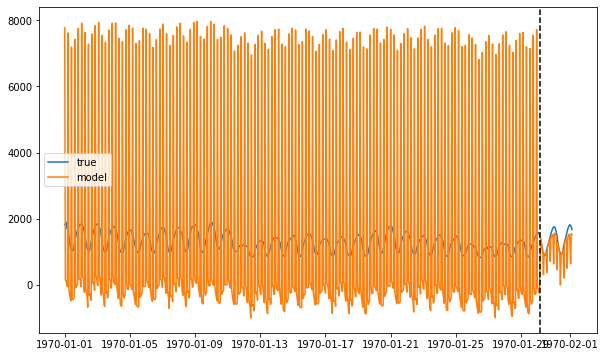

In [8]:
from merlion.transform.moving_average import MovingAverage

print("Moving Average...")
eval_model(get_model(MovingAverage(n_steps=5)), train, test, apply_inverse=False)

print("Moving Average + invert...")
ma = eval_model(get_model(MovingAverage(n_steps=5)), train, test, apply_inverse=True)

INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Difference transform...
Train sMAPE: 49.83
Test  sMAPE: 43.75


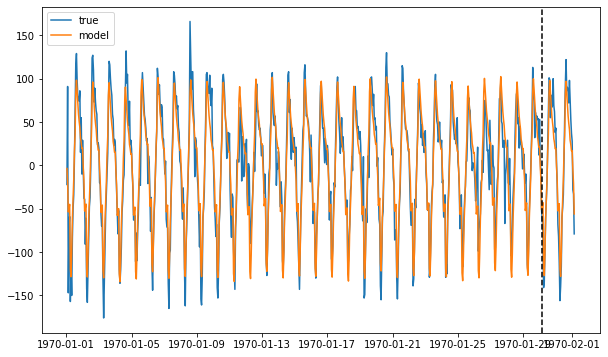

INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Difference transform + invert...


INFO:merlion.transform.base:Transform TemporalResample(aggregation_policy=Mean, granularity=3600.0, missing_value_policy=Interpolate, origin=0.0, remove_non_overlapping=True, trainable_granularity=True) is not strictly invertible. Calling invert() is not guaranteed to recover the original time series exactly!
INFO:merlion.transform.base:Transform TemporalResample(aggregation_policy=Mean, granularity=3600.0, missing_value_policy=Interpolate, origin=0.0, remove_non_overlapping=True, trainable_granularity=True) is not strictly invertible. Calling invert() is not guaranteed to recover the original time series exactly!


Train sMAPE: 6.51
Test  sMAPE: 5.82


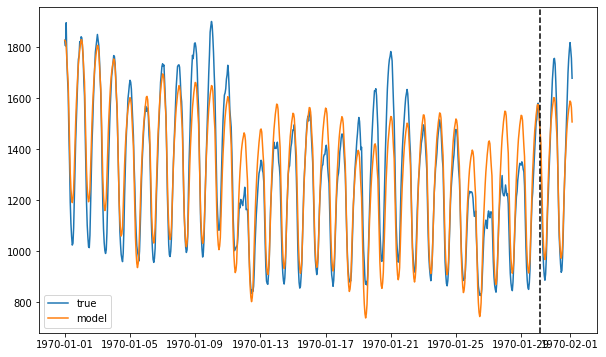

In [9]:
from merlion.transform.moving_average import DifferenceTransform

print("Difference transform...")
eval_model(get_model(DifferenceTransform()), train, test, apply_inverse=False)

print("Difference transform + invert...")
diff = eval_model(get_model(DifferenceTransform()), train, test, apply_inverse=True)

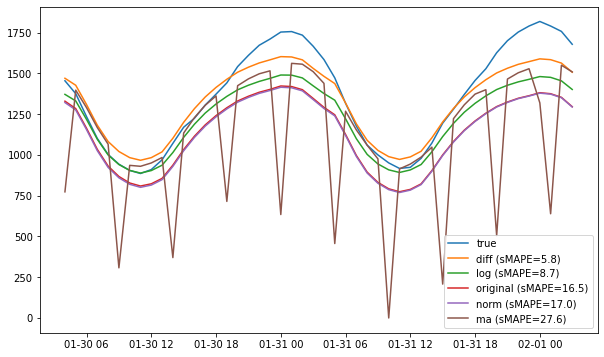

In [10]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(test.to_pd(), label="true")
series = [("original", base), ("norm", norm), ("log", log), ("ma", ma), ("diff", diff)]
smapes = {name: ForecastMetric.sMAPE.value(test, ts) for name, ts in series}

for name, ts in sorted(series, key=lambda ns: smapes[ns[0]]):
    smape = smapes[name]
    if smape <= max(50, sorted(smapes.values())[:2][-1]):
        ax.plot(ts.to_pd(), label=f"{name} (sMAPE={smape:.1f})")
ax.legend()
plt.show()